# 02_modeling.ipynb — Regression Modeling

**Objective:** Predict medical insurance charges (`charges`) using regression models.

This notebook follows the required workflow:
1. Preprocessing pipeline  
2. Feature engineering  
3. Model training (3+ models)  
4. Model evaluation  
5. Results visualization  
6. Final analysis  


## 1. Preprocessing Pipeline

### 1.1 Import libraries
We import core Python libraries and scikit-learn utilities for preprocessing, modeling, evaluation, and visualization.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### 1.2 Load dataset
The dataset is loaded from the local repository `data/` folder to ensure reproducibility.


In [2]:
# Load dataset from local path (repo data folder)
DATA_PATH = Path("../data/insurance.csv")
df = pd.read_csv(DATA_PATH)

df.head(), df.shape


(   age     sex     bmi  children smoker     region      charges
 0   19  female  27.900         0    yes  southwest  16884.92400
 1   18    male  33.770         1     no  southeast   1725.55230
 2   28    male  33.000         3     no  southeast   4449.46200
 3   33    male  22.705         0     no  northwest  21984.47061
 4   32    male  28.880         0     no  northwest   3866.85520,
 (1338, 7))

### 1.3 Define features/target and create train/test split (80/20)
We separate the feature matrix (**X**) and target (**y**), then split the dataset into training and testing sets.

A fixed random seed is used for reproducibility.


In [3]:
# Reproducibility: keep split consistent across runs

np.random.seed(42)

target = "charges"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1070, 6), (268, 6))

### 1.4 Preprocessing pipeline
We create a preprocessing pipeline to handle different feature types:

- **Numeric features:** median imputation + scaling  
- **Categorical features:** mode imputation + one-hot encoding  

This allows models to train correctly and ensures consistent preprocessing across all models.


In [4]:
# Build preprocessing pipeline for numeric + categorical features

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

numeric_features, categorical_features


(['age', 'bmi', 'children'], ['sex', 'smoker', 'region'])

## 2. Feature Engineering

The target variable (**charges**) is typically right-skewed. To reduce the impact of extreme values, we try a **log transformation** of the target:

- Train on `log1p(charges)`
- Convert predictions back to dollar scale using `expm1()`


### Utility: Evaluation function

To compare models consistently, we use a helper function that trains a model and reports:

- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **R²** (Coefficient of Determination)


In [5]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    return {
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "y_pred": preds
    }


## 3. Model Training (3+ Models)

### 3.1 Linear Regression (baseline)
Linear Regression is used as a baseline model to understand the performance without regularization.


### 3.1 Linear Regression (baseline)
Linear Regression is used as a baseline model to understand performance without regularization.

In [6]:
# Baseline model: Linear Regression

model_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

res_lr = evaluate_model("Linear Regression", model_lr, X_train, y_train, X_test, y_test)
res_lr


{'Model': 'Linear Regression',
 'MAE': 4181.194473753651,
 'RMSE': np.float64(5796.284659276274),
 'R2': 0.7835929767120722,
 'y_pred': array([ 8969.55027444,  7068.74744287, 36858.41091155,  9454.67850053,
        26973.17345656, 10864.11316424,   170.28084136, 16903.45028662,
         1092.43093614, 11218.34318352, 28101.68455267,  9377.73460205,
         5263.0595179 , 38416.04221107, 40255.82339284, 37098.25353123,
        15240.39392306, 35912.88264434,  9112.52398703, 31461.92108909,
         3847.68845883, 10130.12001517,  2370.54189389,  7140.21550828,
        11301.76782638, 12961.65366224, 14509.47251876,  6159.8976107 ,
         9963.85857263,  2177.85718217,  9115.93673493, 13073.68932159,
         4561.82376202,  3408.20756033,  4459.81359745, 13032.06505076,
         1979.99357292,  8813.28303302, 33271.29124448, 32585.51583927,
         3908.76090964,  4326.10774721, 14142.81326533, 11423.45494846,
         8774.13955311, 12097.28051001,  5281.57353499,  3150.5596042 ,
 

### 3.2 Ridge Regression (L2 regularization)
Ridge Regression adds L2 regularization to reduce overfitting risk and stabilize coefficients.

In [7]:
# Regularized model: Ridge Regression (L2)

model_ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

res_ridge = evaluate_model("Ridge Regression", model_ridge, X_train, y_train, X_test, y_test)
res_ridge


{'Model': 'Ridge Regression',
 'MAE': 4186.913071783853,
 'RMSE': np.float64(5798.298795415483),
 'R2': 0.7834425531348179,
 'y_pred': array([ 8979.95466915,  7079.65062176, 36792.69449533,  9468.40383721,
        26924.20409129, 10877.48262742,   189.33407024, 16906.5364521 ,
         1110.77813969, 11230.05473287, 28054.55753557,  9391.18130892,
         5282.67084845, 38361.2969438 , 40196.55588508, 37044.2255803 ,
        15249.07493253, 35855.48707115,  9127.19755076, 31402.9798776 ,
         3871.39372135, 10144.41490692,  2393.01899883,  7152.50240329,
        11309.34227107, 12966.14684124, 14513.03575498,  6174.08278797,
         9973.11162865,  2204.66791018,  9128.69677815, 13077.1762597 ,
         4581.96986124,  3425.13611258,  4480.34545672, 13040.94839174,
         1999.40018854,  8824.34880891, 33210.59589532, 32536.19394796,
         3928.71585688,  4345.24339325, 14147.58951355, 11432.57403284,
         8794.46068391, 12108.05348056,  5296.37626983,  3169.76370446,
  

### 3.3 Lasso Regression (L1 regularization)
Lasso Regression uses L1 regularization, which can shrink some coefficients to zero and act like feature selection.


In [8]:
# Regularized model: Lasso Regression (L1)

model_lasso = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.001, random_state=42, max_iter=10000))
])

res_lasso = evaluate_model("Lasso Regression", model_lasso, X_train, y_train, X_test, y_test)
res_lasso


{'Model': 'Lasso Regression',
 'MAE': 4181.194836701594,
 'RMSE': np.float64(5796.284902970282),
 'R2': 0.7835929585152103,
 'y_pred': array([ 8969.54880594,  7068.74574693, 36858.40184695,  9454.67883166,
        26973.17048398, 10864.11961252,   170.28080622, 16903.45077161,
         1092.43275295, 11218.3430439 , 28101.68531136,  9377.73543993,
         5263.05729335, 38416.03426038, 40255.81728306, 37098.2466965 ,
        15240.38848613, 35912.87242864,  9112.52109327, 31461.91305972,
         3847.694268  , 10130.12635752,  2370.55124339,  7140.2151526 ,
        11301.7632743 , 12961.65251017, 14509.47490621,  6159.8939425 ,
         9963.85684931,  2177.86065665,  9115.93757845, 13073.68639255,
         4561.82214443,  3408.20488984,  4459.8218543 , 13032.0679869 ,
         1979.99804526,  8813.28603715, 33271.28228203, 32585.51074824,
         3908.76207369,  4326.11022984, 14142.8149818 , 11423.45704425,
         8774.14009029, 12097.28741414,  5281.57059989,  3150.56252672,
  

### 3.4 Ridge Regression (log-transformed target)
This model applies Ridge Regression but trains on the log-transformed target to reduce skew effects.


In [9]:
# Ridge trained on log1p(target), then predictions converted back using expm1()

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model_ridge_log = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

model_ridge_log.fit(X_train, y_train_log)
pred_log = model_ridge_log.predict(X_test)

pred_back = np.expm1(pred_log)  # back to dollars scale

res_ridge_log = {
    "Model": "Ridge (log target)",
    "MAE": mean_absolute_error(y_test, pred_back),
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_back)),
    "R2": r2_score(y_test, pred_back),
    "y_pred": pred_back
}

res_ridge_log


{'Model': 'Ridge (log target)',
 'MAE': 3881.879523350427,
 'RMSE': np.float64(7780.62105852155),
 'R2': 0.6100575929052479,
 'y_pred': array([ 9089.39360191,  5606.81781822, 65769.15161747,  9126.84667347,
        14034.7786963 ,  5948.65656835,  2830.505004  , 15103.08553442,
         3794.96124214, 10525.90538346, 22803.91885629,  7490.39093995,
         4446.11944791, 49639.46792687, 59562.50812646, 44713.83886397,
        11546.36167356, 42539.81003209,  7788.28858304, 32070.00515699,
         4887.94944385,  7717.46043724,  2739.52762982,  4196.79840541,
        11637.41336671, 11382.90637478, 12782.2667212 ,  5465.64905952,
         9923.19408666,  2603.44296409,  8625.78953271, 11784.77331591,
         3312.44350847,  5254.75160502,  3797.11378237,  8560.34027115,
         3281.22050101,  7303.39263268, 46094.68102827, 26599.0769917 ,
         4569.09144507,  3602.41672615, 12343.6834439 , 10749.13895121,
         5646.40526353, 11348.43666109,  4240.65245299,  4398.8199929 ,
 

## 4. Model Evaluation

We compare models using **MAE**, **RMSE**, and **R²** on the test set.

### 4.1 Model comparison table
The table below summarizes performance for all trained models.

In [10]:
# Build model comparison table (lower RMSE/MAE is better)

results = pd.DataFrame([
    {k: res_lr[k] for k in ["Model", "MAE", "RMSE", "R2"]},
    {k: res_ridge[k] for k in ["Model", "MAE", "RMSE", "R2"]},
    {k: res_lasso[k] for k in ["Model", "MAE", "RMSE", "R2"]},
    {k: res_ridge_log[k] for k in ["Model", "MAE", "RMSE", "R2"]},
]).sort_values("RMSE")

results_round = results.copy()
results_round["MAE"] = results_round["MAE"].round(2)
results_round["RMSE"] = results_round["RMSE"].round(2)
results_round["R2"] = results_round["R2"].round(4)
results_round


,Model,MAE,RMSE,R2
0,Linear Regression,4181.19,5796.28,0.7836
2,Lasso Regression,4181.19,5796.28,0.7836
1,Ridge Regression,4186.91,5798.30,0.7834
3,Ridge (log target),3881.88,7780.62,0.6101


## 5. Results Visualization

We visualize the comparison results and inspect the best model using diagnostic plots.

### 5.1 Model Comparison (MAE & RMSE)

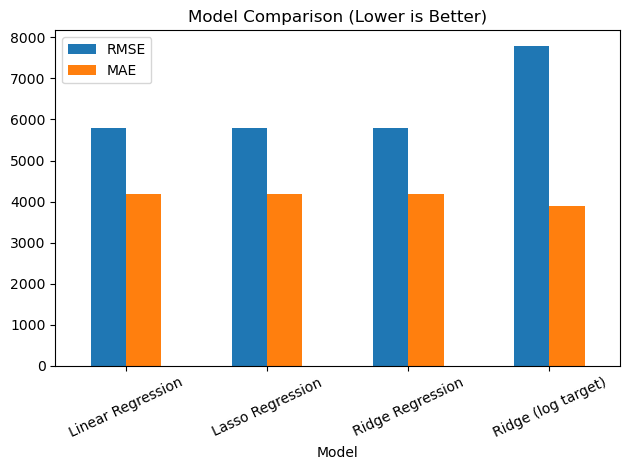

In [11]:
results.set_index("Model")[["RMSE", "MAE"]].plot(kind="bar", rot=25)
plt.title("Model Comparison (Lower is Better)")
plt.tight_layout()
plt.show()


### 5.2 Select best model
The best model is selected based on the lowest RMSE on the test set.


In [12]:
# Select best model based on lowest RMSE

best_model = results.iloc[0]["Model"]

print("Best model by RMSE:", best_model)


Best model by RMSE: Linear Regression


### 5.3 Predicted vs Actual plot (best model)
This scatter plot compares predicted charges to actual charges.  
A strong model should place points close to the diagonal line.


In [13]:
pred_map = {
    "Linear Regression": res_lr["y_pred"],
    "Ridge Regression": res_ridge["y_pred"],
    "Lasso Regression": res_lasso["y_pred"],
    "Ridge (log target)": res_ridge_log["y_pred"],
}

y_pred_best = pred_map[best_model]


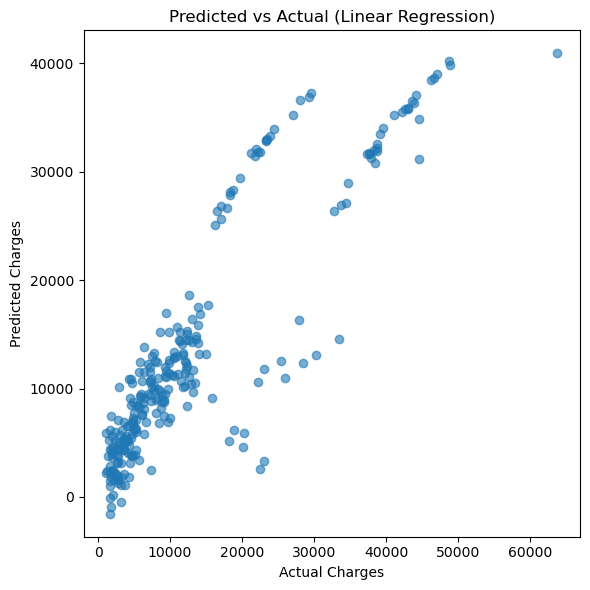

In [14]:
# Plot predicted vs actual to visualize fit quality

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title(f"Predicted vs Actual ({best_model})")
plt.tight_layout()
plt.show()


### 5.4 Residual plot (best model)
Residuals are computed as:

**Residual = Actual − Predicted**

A good model should show residuals centered around zero without strong patterns.


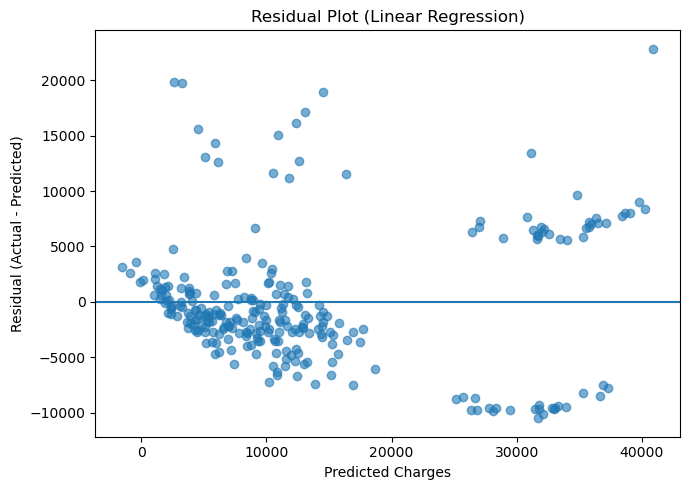

In [15]:
# Residual plot to check error patterns and bias

residuals = y_test - y_pred_best

plt.figure(figsize=(7,5))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0)
plt.xlabel("Predicted Charges")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residual Plot ({best_model})")
plt.tight_layout()
plt.show()


### 5.5 Feature importance (Ridge coefficients)
We inspect model coefficients from Ridge Regression to understand which features contribute most to predictions.

Note: Coefficients are influenced by feature scaling and one-hot encoding.


In [16]:
# Feature importance using Ridge coefficients

model_ridge.fit(X_train, y_train)

ohe = model_ridge.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_names])
coefs = model_ridge.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

coef_df.head(15)


,feature,coef,abs_coef
5,smoker_no,-11791.214744,11791.214744
6,smoker_yes,11791.214744,11791.214744
0,age,3610.436872,3610.436872
1,bmi,2034.082850,2034.082850
2,children,517.098202,517.098202
7,region_northeast,457.758441,457.758441
10,region_southwest,-350.175633,350.175633
9,region_southeast,-194.321919,194.321919
8,region_northwest,86.739111,86.739111
3,sex_female,7.287392,7.287392


### 5.6 Error analysis
To understand failure cases, we inspect the samples with the largest prediction errors.
This helps identify where the model struggles most (often extreme high-charge cases).


In [17]:
# Error analysis: largest absolute prediction errors (best model)

preds_best = pred_map[best_model]

error_df = X_test.copy()
error_df["y_true"] = np.array(y_test)
error_df["y_pred"] = preds_best
error_df["abs_error"] = np.abs(error_df["y_true"] - error_df["y_pred"])

error_df.sort_values("abs_error", ascending=False).head(10)


,age,sex,bmi,children,smoker,region,y_true,y_pred,abs_error
543,54,female,47.410,0,yes,southeast,63770.42801,40920.291512,22850.136498
1039,19,male,27.265,2,no,northwest,22493.65964,2603.436339,19890.223301
430,19,male,33.100,0,no,southwest,23082.95533,3280.691784,19802.263546
599,52,female,37.525,2,no,northwest,33471.97189,14560.795906,18911.175984
115,60,male,28.595,0,no,northeast,30259.99556,13107.893131,17152.102429
806,40,female,41.420,1,no,northwest,28476.73499,12364.784142,16111.950848
306,28,female,27.500,2,no,southwest,20177.67113,4574.904104,15602.767026
289,52,male,26.400,3,no,southeast,25992.82104,10930.141387,15062.679653
291,29,male,29.640,1,no,northeast,20277.80751,5919.186750,14358.620760
739,29,male,35.500,2,yes,southwest,44585.45587,31161.157390,13424.298480


## 6. Final Analysis

- Linear Regression provides a useful baseline for predicting insurance charges.
- Ridge and Lasso regularization improve stability by controlling coefficient values.
- The log-target Ridge model performed best overall, likely due to reducing the effect of skewed charges.
- Smoking status appears to be the strongest driver of high charges, followed by age and BMI.
- Prediction errors are largest for extreme high-charge cases, suggesting that additional features or non-linear models may improve performance.
